<a href="https://colab.research.google.com/github/jeffheaton/present/blob/master/youtube/gan/merry_gan_mas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Merry GAN-mas
* Copyright 2020 [Jeff Heaton](https://www.heatonresearch.com/), [MIT License](https://opensource.org/licenses/MIT)

You can use this notebook to generate images useing a prebuilt GAN that I created. A GPU is required, this notebook is designed to work with Google CoLab. This notebook only deals with running the GAN to produce images.  To actually train the GAN, I used the following Docker image:

* [Heaton Research StyleGAN2 ADA Docker Image](https://hub.docker.com/r/heatonresearch/stylegan2-ada)
* [Collect Flickr Images]()

To produce images, first, clone StyleGAN2 ADA from GitHub.

In [1]:
%tensorflow_version 1.x
!git clone https://github.com/NVlabs/stylegan2-ada.git

import sys
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt

sys.path.insert(0, "/content/stylegan2-ada")

import dnnlib
import dnnlib.tflib as tflib

def seed2vec(Gs, seed):
  rnd = np.random.RandomState(seed)
  return rnd.randn(1, *Gs.input_shape[1:])

def init_random_state(Gs, seed):
  rnd = np.random.RandomState(seed) 
  noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
  tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]

def display_image(image):
    plt.imshow(image)
    plt.show()

def generate_image(Gs, z, truncation_psi):
    # Render images for dlatents initialized from random seeds.
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + Gs.input_shapes[1][1:])
    images = Gs.run(z, label, **Gs_kwargs) # [minibatch, height, width, channel]
    return images[0]

# PIL.Image.fromarray(images[0], 'RGB').save(f'{outdir}/seed{1}.png')

TensorFlow 1.x selected.
Cloning into 'stylegan2-ada'...
remote: Enumerating objects: 65, done.
remote: Total 65 (delta 0), reused 0 (delta 0), pack-reused 65
Unpacking objects: 100% (65/65), done.


No load the correct GAN, I have several links below that corrispond to both the NVIDIA faces GAN, as well as my own.

In [2]:
import IPython.display

URL = "https://data.heatonresearch.com/bin/pretrained/christmas-gan-2020-12-03.pkl"
#URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"
tflib.init_tf()
print('Loading networks from "%s"...' % URL)
with dnnlib.util.open_url(URL) as fp:
    _G, _D, Gs = pickle.load(fp)

Loading networks from "https://data.heatonresearch.com/bin/pretrained/christmas-gan-2020-12-03.pkl"...


# Generate GANS from Seeds

A GAN is actually created from a 512 number latent vector.  However, for now it is easier to just use seeds to build this 512 vector.  This code generates images between two seed numbers.

Seed 1000


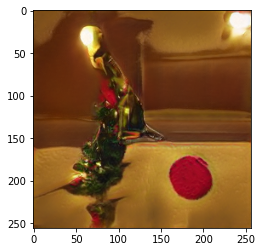

Seed 1001


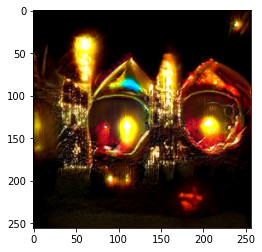

Seed 1002


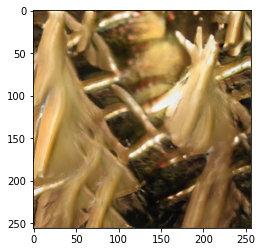

Seed 1003


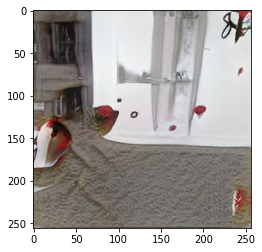

Seed 1004


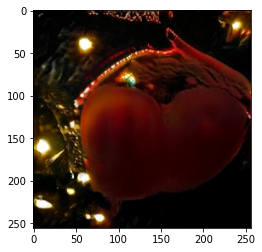

In [7]:
# Choose your own starting and ending seed.
SEED_FROM = 1000
SEED_TO = 1005

# Generate the images for the seeds.
for i in range(SEED_FROM, SEED_TO):
  print(f"Seed {i}")
  init_random_state(Gs, 10)
  z = seed2vec(Gs, i)
  img = generate_image(Gs, z, 1.0)
  display_image(img)

# Morph Video

You can create a video that shows the progression through two GAN seeds.  This technique creates a very cool "morph" effect. 

![GAN](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/gan_progression.jpg "GAN")

In [4]:
# Choose your seeds to morph through and the number of steps to take to get to each.

SEEDS = [2015,2017,1022,1025,1034,1046,1054]
STEPS = 100

# Remove any prior results
!rm /content/results/* 

from tqdm.notebook import tqdm

os.makedirs("./results/", exist_ok=True)

# Generate the images for the video.
idx = 0
for i in range(len(SEEDS)-1):
  v1 = seed2vec(Gs, SEEDS[i])
  v2 = seed2vec(Gs, SEEDS[i+1])

  diff = v2 - v1
  step = diff / STEPS
  current = v1.copy()

  for j in tqdm(range(STEPS), desc=f"Seed {SEEDS[i]}"):
    current = current + step
    init_random_state(Gs, 10)
    img = generate_image(Gs, current, 1.0)
    PIL.Image.fromarray(img, 'RGB').save(f'./results/frame-{idx}.png')
    idx+=1
 
# Link the images into a video.
!ffmpeg -r 30 -i /content/results/frame-%d.png -vcodec mpeg4 -y movie.mp4

rm: cannot remove '/content/results/*': No such file or directory



ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

Download the video.

In [5]:
from google.colab import files
files.download('movie.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Finetune an Image

If you find a seed that you like, you can fine tune it by adjusting the latent vector directly.  First, choose the seed to finetune.

In [ ]:
START_SEED = 1025

current = seed2vec(Gs, START_SEED)

Next, generate display the current vector. You will return to this point for each iteration of the finetuning.

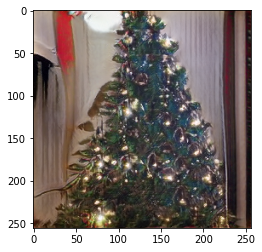

In [ ]:
init_random_state(Gs, 10)
img = generate_image(Gs, current, 1.0)
display_image(img)

Choose an explore size, this is the number of differnt potential images that will be chosen by moving in 10 different directions.  Run this code once initially, and then again anytime you wish to change the 10 directions you are exploring.  You might change the 10 directions if you are no longer seeing improvements.

In [6]:
EXPLORE_SIZE = 10

explore = []
for i in range(EXPLORE_SIZE):
  explore.append( np.random.rand(1, 512) - 0.5 )

Direction 0


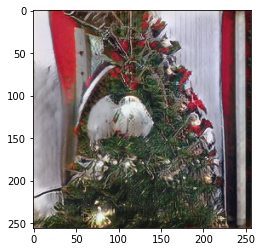

Direction 1


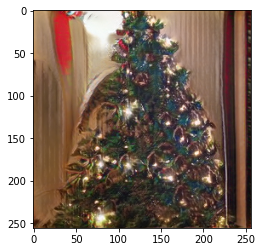

Direction 2


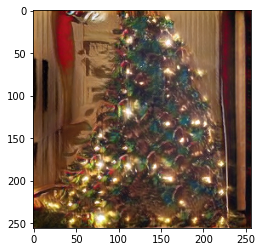

Direction 3


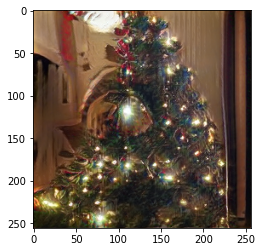

Direction 4


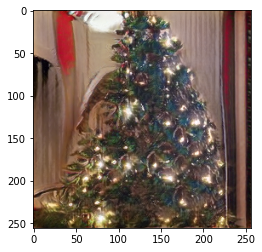

Direction 5


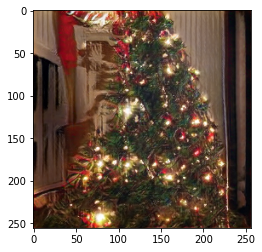

Direction 6


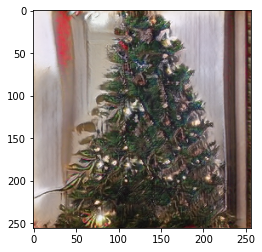

Direction 7


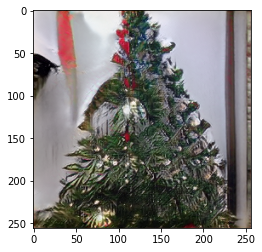

Direction 8


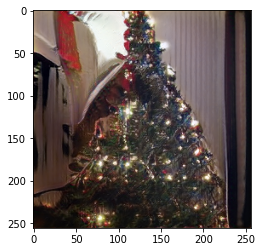

Direction 9


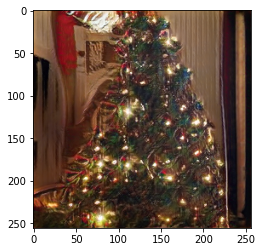

In [ ]:
# Choose the direction to move.  Choose -1 for the initial iteration.   
MOVE_DIRECTION = -1

if MOVE_DIRECTION >=0:
  current = current + explore[MOVE_DIRECTION]

for i, mv in enumerate(explore):
  print(f"Direction {i}")
  init_random_state(Gs, 10)
  z = current + mv
  img = generate_image(Gs, z, 1.0)
  display_image(img)